<a href="https://colab.research.google.com/github/shyamjith94/PyTorch/blob/main/BinaryCensusClassificationIncome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
%%capture
!pip install torch torchvision

In [25]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch, torchvision
import torch.nn as NN
import torch.functional as F

from torch.utils.data import DataLoader, Dataset 

from sklearn.utils import shuffle

from math import radians, cos, sin, asin, sqrt

In [26]:
data  = pd.read_csv("/content/drive/MyDrive/PyTorch/Data/income.csv")

In [27]:
data.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30000 non-null  int64 
 1   sex             30000 non-null  object
 2   education       30000 non-null  object
 3   education-num   30000 non-null  int64 
 4   marital-status  30000 non-null  object
 5   workclass       30000 non-null  object
 6   occupation      30000 non-null  object
 7   hours-per-week  30000 non-null  int64 
 8   income          30000 non-null  object
 9   label           30000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 2.3+ MB


In [29]:
data.dtypes

age                int64
sex               object
education         object
education-num      int64
marital-status    object
workclass         object
occupation        object
hours-per-week     int64
income            object
label              int64
dtype: object

In [30]:
data.columns

Index(['age', 'sex', 'education', 'education-num', 'marital-status',
       'workclass', 'occupation', 'hours-per-week', 'income', 'label'],
      dtype='object')

In [31]:
check_unique = ['sex', 'education', 'education-num', 'marital-status',
       'workclass', 'occupation', ]
for col in check_unique:
    print(col,"\n", data[col].unique())

sex 
 ['Male' 'Female']
education 
 ['HS-grad' 'Masters' 'Prof-school' '11th' '12th' '5th-6th' 'Some-college'
 'Bachelors' 'Assoc-acdm' '9th' 'Assoc-voc' '10th' '7th-8th' 'Doctorate']
education-num 
 [ 9 14 15  7  8  3 10 13 12  5 11  6  4 16]
marital-status 
 ['Never-married' 'Married' 'Divorced' 'Widowed' 'Separated'
 'Married-spouse-absent']
workclass 
 ['Private' 'Local-gov' 'Self-emp' 'Federal-gov' 'State-gov']
occupation 
 ['Craft-repair' 'Exec-managerial' 'Prof-specialty' 'Farming-fishing'
 'Handlers-cleaners' 'Machine-op-inspct' 'Adm-clerical' 'Other-service'
 'Sales' 'Tech-support' 'Protective-serv' 'Transport-moving']


**Seperate Cont and Cate columns**

In [32]:
cat_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']
y_cols = ['label']


print(f'cat_cols length \t{len(cat_cols)}')
print(f'cont_cols length\t{len(cont_cols)}')
print(f'y col length \t{len(y_cols)}')

cat_cols length 	5
cont_cols length	2
y col length 	1


In [33]:
data['label'].value_counts()

0    21700
1     8300
Name: label, dtype: int64

In [34]:
for cat in cat_cols:
    data[cat] = data[cat].astype('category')
data.dtypes

age                  int64
sex               category
education         category
education-num        int64
marital-status    category
workclass         category
occupation        category
hours-per-week       int64
income              object
label                int64
dtype: object

**ShuffleData**

In [35]:
data = shuffle(data, random_state=101)
data.reset_index(drop=True, inplace=True)
data.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,23,Female,HS-grad,9,Never-married,Private,Other-service,50,<=50K,0
1,37,Female,Prof-school,15,Married,State-gov,Prof-specialty,39,>50K,1
2,34,Male,Some-college,10,Divorced,Private,Adm-clerical,40,<=50K,0
3,31,Male,HS-grad,9,Married,Private,Craft-repair,40,>50K,1
4,20,Female,Some-college,10,Never-married,Private,Sales,25,<=50K,0


**Setting embedding Size**

In [36]:
cat_size = [len(data[col].cat.categories) for col in cat_cols]
cat_size

[2, 14, 6, 5, 12]

In [37]:
emb_size = [(size, min(50, (size+1)//2)) for size in cat_size]
emb_size

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

**Create Array of categories values**

In [38]:
sx = data['sex'].cat.codes.values
educatn = data['education'].cat.codes.values
mr_stat = data['marital-status'].cat.codes.values
wrk_clas = data['workclass'].cat.codes.values
occupa = data['occupation'].cat.codes.values

In [39]:
cats = np.stack([sx,educatn, mr_stat, wrk_clas, occupa], axis=1)
cats[:5]

array([[ 0, 10,  3,  2,  6],
       [ 0, 12,  1,  4,  7],
       [ 1, 13,  0,  2,  0],
       [ 1, 10,  1,  2,  1],
       [ 0, 13,  3,  2,  9]], dtype=int8)

In [40]:
cats = torch.tensor(cats, dtype=torch.int64)

In [41]:
conts = np.stack([data[cont].values for cont in cont_cols], axis=1)
conts[:5]

array([[23, 50],
       [37, 39],
       [34, 40],
       [31, 40],
       [20, 25]])

In [42]:
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[23., 50.],
        [37., 39.],
        [34., 40.],
        [31., 40.],
        [20., 25.]])

In [43]:
y_value = data[y_cols].values

In [44]:
# need flatten this array
y_value = torch.tensor(y_value).flatten()
y_value[:5]

tensor([0, 1, 0, 1, 0])

**Create Train And Test Sets**

In [45]:
b = 30000
t = 5000

cat_train = cats[:b-t]
cat_test = cats[b-t:b]

cont_train = conts[:b-t]
cont_test = conts[b-t:b]

y_train = y_value[:b-t]
y_test  = y_value[b-t:b]

In [46]:
print(len(cat_train))
print(len(cat_test))
print(len(cont_train))
print(len(cont_test))
print(len(y_train))
print(len(y_test))

25000
5000
25000
5000
25000
5000


**Model Creation And Training**

In [78]:
class TablarModel(NN.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()

        self.embeds = NN.ModuleList([NN.Embedding(ni, nf) for ni, nf in emb_szs])
        self.dropout = NN.Dropout(p)
        self.bn_cont = NN.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum((nf for ni, nf in emb_szs))
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(NN.Linear(n_in, i))
            layerlist.append(NN.ReLU(inplace=True))
            layerlist.append(NN.BatchNorm1d(i))
            layerlist.append(NN.Dropout(p))
            n_in = i
        layerlist.append(NN.Linear(layers[-1], out_sz))

        self.layers =  NN.Sequential(*layerlist)

        def forward(self, x_cat, x_cont):
            embedding = []
            for i,e in enumerate(self.embeds):
                embedding.append(e(x_cat[:,i]))
            
            x = torch.cat(embedding, 1)
            x = self.dropout(x)

            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1)
            x = self.layers(x)
            return x

In [79]:
torch.manual_seed(33)

In [80]:
conts.shape[1]

2

In [81]:
model = TabularModel(emb_size, conts.shape[1], 2, [50], p=0.4)

In [82]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [83]:
criterion =  NN.CrossEntropyLoss() # classification
optimizer = torch.optim.Adam(model.parameters(), 0.001)


In [84]:
import time

start_time = time.time()

epochs = 300
losses = []
for i in range(epochs):
    i+=1
    y_pred = model(cat_train, cont_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)

    if i%25 == 1:
        print(f'epochs {i:3} loss {loss.item():10.8f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print(f'epochs {i:3} loss {loss.item():10.8f}')
print(f'duration {time.time() - start_time:0f} secound')


epochs   1 loss 0.81344724
epochs  26 loss 0.59464002
epochs  51 loss 0.51533061
epochs  76 loss 0.46403298
epochs 101 loss 0.42922878
epochs 126 loss 0.40061814
epochs 151 loss 0.37124804
epochs 176 loss 0.35843456
epochs 201 loss 0.34799665
epochs 226 loss 0.33587816
epochs 251 loss 0.33125827
epochs 276 loss 0.32283622
epochs 300 loss 0.31732056
duration 141.471617 secound


Text(0, 0.5, 'Losses')

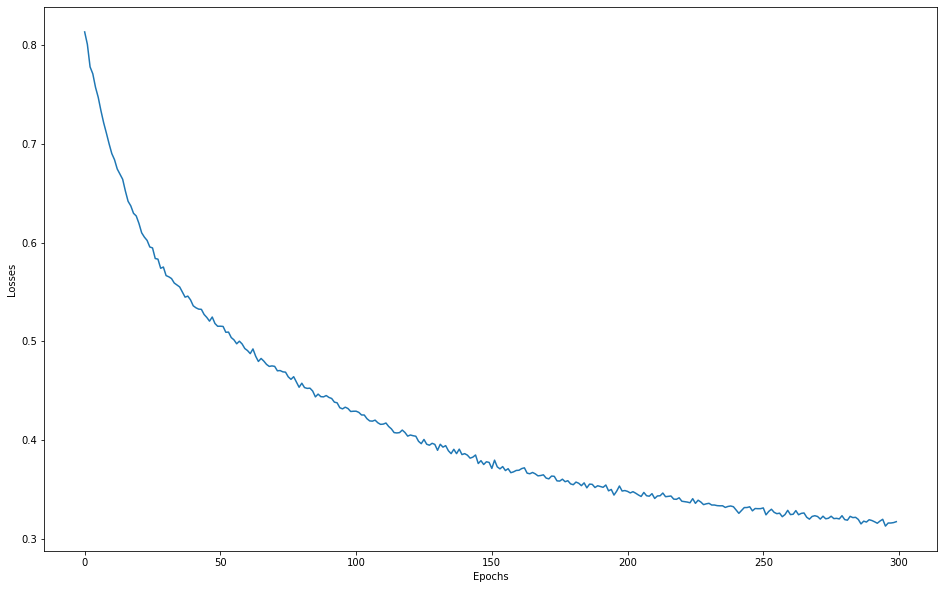

In [85]:
plt.figure(figsize=(16,10))
plt.plot(range(epochs), losses)
plt.xlabel("Epochs")
plt.ylabel("Losses")

**Evaluation**

In [87]:
with torch.no_grad():
    y_val = model(cat_test, cont_test)
    loss = criterion(y_val, y_test)
print(loss)

tensor(0.3353)


In [90]:
row = len(y_test)
correct = 0

for i in range(row):
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(100*correct/row, "% correct we got")

84.24 % correct we got


In [109]:
def test_data(mdl):
    age = float(input("person age 18-90 \t"))
    sex = input("person sex(Male/Female)\t").capitalize()
    edn = int(input("education level 3-16\t"))
    mar = input("person merital status\t").capitalize()
    wrk = input("person work class\t").capitalize()
    occ = input("person occupation\t").capitalize()
    hrs = float(input("working hors per/week\t"))

    # process data
    sex_d = {'Female':0 , 'Male':1}
    mar_d = {'Never-married':3, 'Married':1, 'Divorced':0, 'Widowed':5, 'Separated':4,
 '          Married-spouse-absent':2}
    wrk_d = {'Federal-gov':0, 'Local-gov':1, 'Private':2, 'Self-emp':3, 'State-gov':4}
    occ_d = {'Adm-clerical':0, 'Craft-repair':1, 'Exec-managerial':2, 'Farming-fishing':3, 'Handlers-cleaners':4,
            'Machine-op-inspct':5, 'Other-service':6, 'Prof-specialty':7, 'Protective-serv':8, 'Sales':9,
            'Tech-support':10, 'Transport-moving':11}
    
    sex = sex_d[sex]
    mar = mar_d[mar]
    wrk = wrk_d[wrk]
    occ = occ_d[occ]

    cats = torch.tensor([sex, edn, mar, wrk, occ], dtype=torch.int64).reshape(1,-1)
    conts = torch.tensor([age, hrs], dtype=torch.float).reshape(1,-1)

    model.eval() 

    with torch.no_grad():
        z = mdl(cats, conts).argmax().item()
    print(f'\n predicted label is \t{z}')


In [110]:
test_data(model)

person age 18-90 	35
person sex(Male/Female)	Female
education level 3-16	4
person merital status	Married
person work class	Private
person occupation	Craft-repair
working hors per/week	50

 predicted label is 	0
